In [1]:
import pandas as pd 
import numpy as np

import sys
import matplotlib.pyplot as plt 
import math 
import random

sys.path.append("../IDL")
import entropy_estimators  as ee

In /home/james/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/james/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/james/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/james/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/james/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [37]:
def euler(M, T, S, sigma, r, beta, num_series, rho):
    dt = T/M
    S_values = np.zeros((num_series, M))
    S_values[:,0] = S

    for m in range(1, M):

        shared_Zm = random.gauss(0, 1)

        for n in range(num_series):
            Zm = random.gauss(0, 1)
            S_values[n, m] = S_values[n, m-1] + r*S_values[n, m-1]*dt + sigma*S_values[n, m-1]*math.sqrt(dt)*Zm + beta*rho*S_values[n, m-1]*math.sqrt(dt)*shared_Zm 

    return S_values

def log_returns(series):
    series_log = np.log(series)
    shifted_log = np.log(np.roll(series.copy(), 1))
    ## ignore first rolled values
    return shifted_log[1:] - series_log[1:]

def MI(s1, s2):
    l = len(s1)
    v1 = s1.reshape(l, 1)
    v2 = s2.reshape(l, 1)
    return ee.mi(v1, v2)

def MIcorr2dist(corr):
    maxx = 2
    t = 2*(maxx-corr)
    return np.where(t>0, np.sqrt(t), 0)

In [11]:
res = euler(M=365, T=1, S=100, sigma=0.2, r=0.06, beta=0.8, num_series=5, rho=0.3)
print(res)

[[100.          97.74711983  98.10613912 ... 105.99864179 108.90860228
  111.41439211]
 [100.          98.2082122   96.3280668  ...  98.45380799 100.75659839
   98.62233817]
 [100.          97.55590273  98.66336594 ... 140.67639236 142.87298619
  145.28443694]
 [100.          96.77039154  96.55414279 ...  76.34956377  78.75290052
   79.11067475]
 [100.          98.55347896  97.54819955 ...  75.27059383  77.14618628
   76.46363049]]


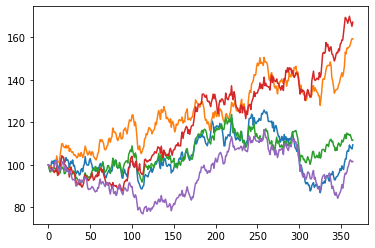

In [7]:
for i in range(res.shape[0]):
    plt.plot(res[i, :])

In [8]:
res_corr = euler(M=365, T=1, S=100, sigma=0.2, r=0.06, beta=0.8, num_series=5, rho=0.7)

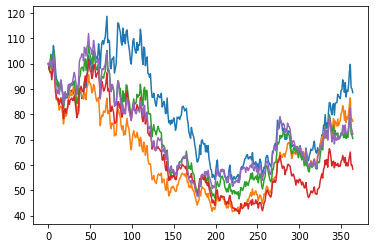

In [9]:
for i in range(res.shape[0]):
    plt.plot(res_corr[i, :])

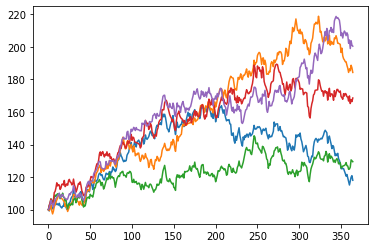

In [10]:
res_corr = euler(M=365, T=1, S=100, sigma=0.2, r=0.06, beta=0.3, num_series=5, rho=0.7)
for i in range(res.shape[0]):
    plt.plot(res_corr[i, :])

In [16]:
## res_logret = log_returns(res_corr)
res_logret = np.apply_along_axis(log_returns, 1, res_corr)
print(res_corr.shape)
print(res_logret.shape)

(5, 365)
(5, 364)


In [21]:
res_logret_df = pd.DataFrame(res_logret)
dist = MIcorr2dist(res_logret_df.corr(method=MI))
print(dist)

[[1.41421356 2.         2.01198654 ... 2.         1.96360141 1.88870101]
 [2.         1.41421356 1.85011405 ... 2.         2.04752517 2.01198654]
 [2.01198654 1.85011405 1.41421356 ... 2.04752517 2.0357479  2.0357479 ]
 ...
 [2.         2.         2.04752517 ... 1.41421356 2.0357479  2.02390209]
 [1.96360141 2.04752517 2.0357479  ... 2.0357479  1.41421356 1.98794119]
 [1.88870101 2.01198654 2.0357479  ... 2.02390209 1.98794119 1.41421356]]


In [80]:
## create p on the x axis, Mean IDL on the y axis 

p_vals = np.linspace(0.01, 2, 30)
sig_vals = np.linspace(0.01, 0.9, 10)
corr_res = np.zeros((sig_vals.shape[0], p_vals.shape[0]))

for j, sig_val in enumerate(sig_vals):
    for i, val in enumerate(p_vals):
        res = euler(M=120, T=1, S=100, sigma=sig_val, r=0.06, beta=0.8, num_series=5, rho=val)
        res_logret = np.apply_along_axis(log_returns, 1, res)
        res_logret_df = pd.DataFrame(res_logret.T).corr(method=MI)
        corr_res[j, i] = np.mean(np.array(res_logret_df).flatten())

##print(corr_res)

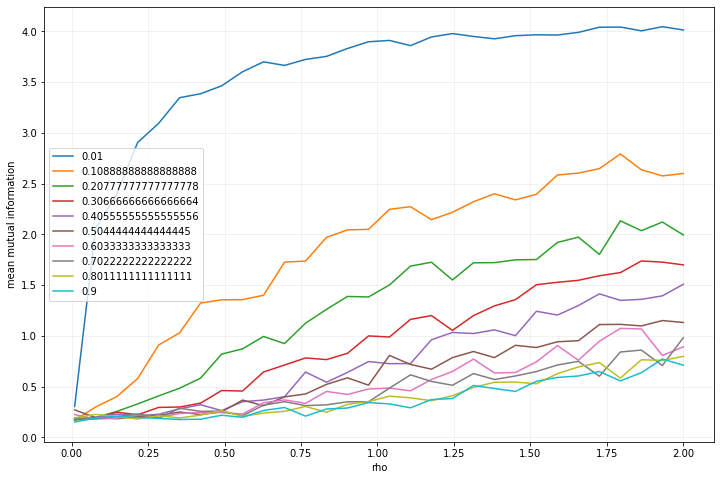

In [82]:
fig = plt.figure(figsize=(12, 8))
for j, sig_val in enumerate(sig_vals):
    plt.plot(p_vals, corr_res[j,:], label=f"{sig_val}")
plt.legend()
plt.xlabel("rho")
plt.ylabel("mean mutual information")
plt.grid(alpha=0.2)
plt.show()